## Import Packages and Set Directories

In [1]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

In [4]:
# Read Fama-French 5 factors and momentum factors
ff6_weekly_df = pd.read_csv(os.path.join(factor_dir, 'ff6_weekly.csv'))
ff6_monthly_df = pd.read_csv(os.path.join(factor_dir, 'ff6_monthly.csv'))
ff6_yearly_df = pd.read_csv(os.path.join(factor_dir, 'ff6_yearly.csv'))

# Read HXZ 4 factors
hxz_weekly_df = pd.read_csv(os.path.join(factor_dir, 'hxz_weekly.csv'))
hxz_monthly_df = pd.read_csv(os.path.join(factor_dir, 'hxz_monthly.csv'))
hxz_yearly_df = pd.read_csv(os.path.join(factor_dir, 'hxz_yearly.csv'))

# Read Credit risk and liquidity
our_weekly_df = pd.read_csv(os.path.join(factor_dir, 'ourfactor_weekly.csv'))
our_monthly_df = pd.read_csv(os.path.join(factor_dir, 'ourfactor_monthly.csv'))
our_yearly_df = pd.read_csv(os.path.join(factor_dir, 'ourfactor_yearly.csv'))

# Combine the weekly factors dataframes
factors_weekly_df = pd.merge(ff6_weekly_df, hxz_weekly_df, on='Date', how='inner')
factors_weekly_df = pd.merge(factors_weekly_df, our_weekly_df, on='Date', how='inner')
factors_weekly_df.drop(columns=['RF_HXZ', 'Mkt-RF_HXZ'], inplace=True)
# factors_weekly_df.to_csv(os.path.join(factor_dir, 'factors_weekly.csv'), index=False)

# Combine the monthly factors dataframes
factors_monthly_df = pd.merge(ff6_monthly_df, hxz_monthly_df, on='Year_Month', how='inner')
factors_monthly_df = pd.merge(factors_monthly_df, our_monthly_df, on='Year_Month', how='inner')
factors_monthly_df['Year_Month'] = pd.to_datetime(factors_monthly_df['Year_Month']).dt.to_period('M')
factors_monthly_df.drop(columns=['RF_HXZ', 'Mkt-RF_HXZ'], inplace=True)
# factors_monthly_df.to_csv(os.path.join(factor_dir, 'factors_monthly.csv'), index=False)

# Combine the yearly factors dataframes
factors_yearly_df = pd.merge(ff6_yearly_df, hxz_yearly_df, on='Year', how='inner')
factors_yearly_df = pd.merge(factors_yearly_df, our_yearly_df, on='Year', how='inner')
factors_yearly_df.drop(columns=['RF_HXZ', 'Mkt-RF_HXZ'], inplace=True)

# Read Benchmark price data
NYSE_SP500 = pd.read_csv(os.path.join(data_dir, 'NYSE_SP500.csv'))

# Read optimal portfolio data
opt_weekly_df = pd.read_csv(os.path.join(data_dir, 'sample_stock', 'optimal_pfo_return_weekly.csv'))
opt_monthly_df = pd.read_csv(os.path.join(data_dir, 'sample_stock', 'optimal_pfo_return_monthly.csv'))
opt_monthly_df['Year_Month'] = pd.to_datetime(opt_monthly_df['Date']).dt.to_period('M')
opt_yearly_df = pd.read_csv(os.path.join(data_dir, 'sample_stock', 'optimal_pfo_return_yearly.csv'))

## 1. EDA on Factors

Factors from French's data library:

* **HML** (high minus low, value factor): average return on the two high B/M (value) portfolios minus average return on the two low B/M (growth) portfolios.
* **MOM** (momentum): average return on the two high prior return portfolios minus the average return on the two low prior return portfolios.

Factors from HXZ Global q-factor data library:

* **EG** (expected growth): estimated via cross-sectional forecasting regressions of investment-to-assets changes on current Tobin’s q, operating cash flows, and changes in return on equity


### 1.1 Factors Correlation Heatmap 

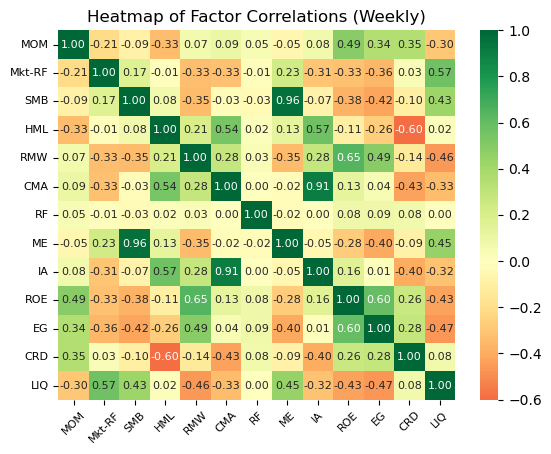

In [3]:
corr_matrix = factors_weekly_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Weekly)')
# plt.savefig(os.path.join(graph_dir, 'factors_heatmap.png'))
plt.show()

### 1.2 Return Difference on Factors

Calculate the Compound annual growth rate (CAGR) and annual variance for each factors.

In [6]:
# Calculate CAGR for each factor
periods = factors_yearly_df['Year'].iloc[-1] - factors_yearly_df['Year'].iloc[0]
cumulative_returns = (1 + factors_yearly_df.iloc[:, 1:] / 100).cumprod() - 1
cagr_results = ((1 + cumulative_returns.iloc[-1]) ** (1 / periods) - 1) * 100

# Calculate annual variance for each factor
variance_results = factors_yearly_df.iloc[:, 1:].var(ddof=1)

Use S&P 500 and NYSE index as benchmark, calculate the CAGR and variance form the indices. Plot the CAGR and annual variance for each factors and benchmark, sort by CAGR.

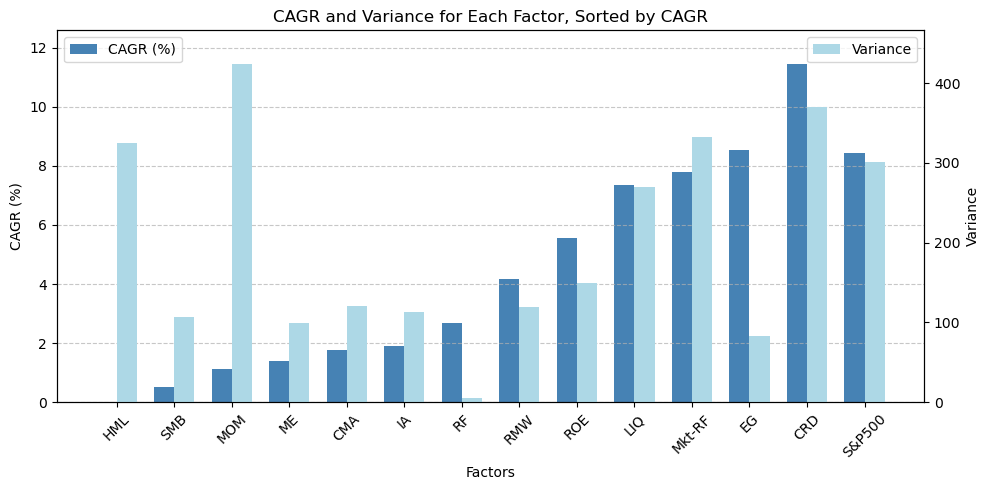

In [10]:
# Filter NYSE_SP500 data
NYSE_SP500['Date'] = pd.to_datetime(NYSE_SP500['Date'])
min_year, max_year = factors_yearly_df['Year'].min(), factors_yearly_df['Year'].max()
NYSE_SP500 = NYSE_SP500[(NYSE_SP500['Date'].dt.year>=min_year) & (NYSE_SP500['Date'].dt.year<=max_year)]

# Resample to get annual last price
annual_df = NYSE_SP500.resample('Y', on='Date').last()
annual_returns = annual_df.pct_change().dropna() * 100

# Calculate CAGR for benchmark
def calculate_cagr(start_value, end_value, periods):
    return ((end_value / start_value) ** (1 / periods) - 1) * 100
periods = max_year - min_year
cagr_nyse = calculate_cagr(annual_df['CloseNYSE'].iloc[0], annual_df['CloseNYSE'].iloc[-1], periods)
cagr_sp500 = calculate_cagr(annual_df['CloseSP500'].iloc[0], annual_df['CloseSP500'].iloc[-1], periods)

# Calculate variance for annual returns of NYSE and S&P 500
variance_nyse = annual_returns['CloseNYSE'].var()
variance_sp500 = annual_returns['CloseSP500'].var()

# Sorting the results based on CAGR
sorted_indices = cagr_results.argsort()
sorted_cagr = cagr_results[sorted_indices]
sorted_variance = variance_results[sorted_indices]
sorted_cagr['S&P500'] = cagr_sp500  # add S&P 500 as benchmark
sorted_variance['S&P500'] = variance_sp500

# Plotting
fig, ax1 = plt.subplots(figsize=(10,5))
bar_width = 0.35  # Width of the bars
indices = np.arange(len(sorted_cagr))

# Plot CAGR results and variance
cagr_bars = ax1.bar(indices - bar_width / 2, sorted_cagr, bar_width, label='CAGR (%)', color='steelblue')
ax2 = ax1.twinx()  # Create second y-axis for the variance
variance_bars = ax2.bar(indices + bar_width / 2, sorted_variance, bar_width, label='Variance', color='lightblue')

# Set labels and title
ax1.set_xlabel('Factors')
ax1.set_ylabel('CAGR (%)')
ax2.set_ylabel('Variance')
plt.title('CAGR and Variance for Each Factor, Sorted by CAGR')
ax1.set_ylim([0, max(sorted_cagr) * 1.1])  # 10% above max for CAGR
ax2.set_ylim([0, max(sorted_variance) * 1.1])  # 10% above max for Variance

# Set x-ticks, add grid lines and legends
ax1.set_xticks(indices)
ax1.set_xticklabels(sorted_cagr.index, rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save and output
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'factors_return_var.png'))
plt.show()

## 1.3 Anomalies from the CAGR Plot

HML and MOM experience unusual high variance for its CAGR, whereas EG have low variance and high CAGR.

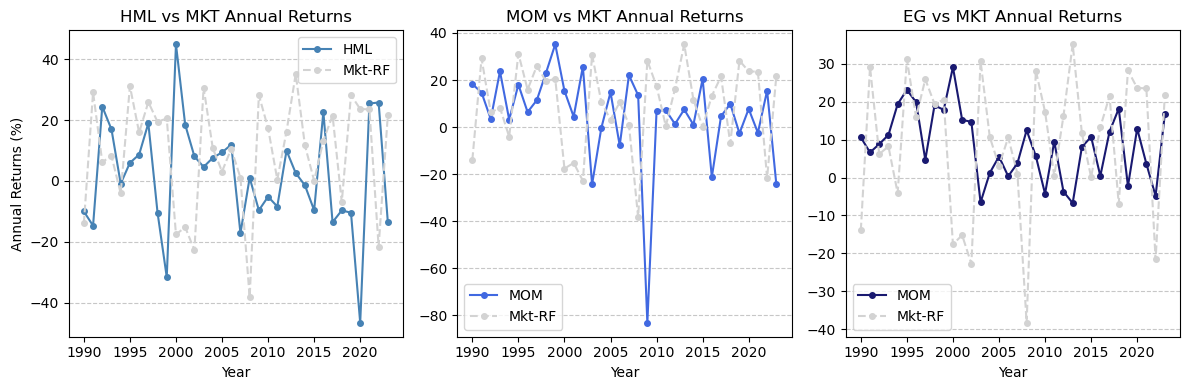

In [7]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: 'HML' and 'Mkt-RF'
ax1.plot(factors_yearly_df['Year'], factors_yearly_df['HML'], label='HML', color='steelblue', marker='o', markersize=4)
ax1.plot(factors_yearly_df['Year'], factors_yearly_df['Mkt-RF'], label='Mkt-RF', color='lightgray', linestyle='--', marker='o', markersize=4)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Returns (%)')
ax1.set_title('HML vs MKT Annual Returns')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines

# Second subplot: 'MOM' and 'Mkt-RF'
ax2.plot(factors_yearly_df['Year'], factors_yearly_df['MOM'], label='MOM', color='royalblue', marker='o', markersize=4)
ax2.plot(factors_yearly_df['Year'], factors_yearly_df['Mkt-RF'], label='Mkt-RF', color='lightgray', linestyle='--', marker='o', markersize=4)
ax2.set_xlabel('Year')
ax2.set_title('MOM vs MKT Annual Returns')
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines

# Third subplot: 'EG' and 'Mkt-RF'
ax3.plot(factors_yearly_df['Year'], factors_yearly_df['EG'], label='MOM', color='midnightblue', marker='o', markersize=4)
ax3.plot(factors_yearly_df['Year'], factors_yearly_df['Mkt-RF'], label='Mkt-RF', color='lightgray', linestyle='--', marker='o', markersize=4)
ax3.set_xlabel('Year')
ax3.set_title('EG vs MKT Annual Returns')
ax3.legend()
ax3.grid(True, axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines

# Show and save the plot
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'anomaly_returns.png'))
plt.show()

## 2. Preliminary Analysis

## 2.1 Prepare Factors and Stock data

Create weekly and monthly dataframes for regression

In [87]:
def create_year_week(df):
    tmp = df.copy()    
    tmp['Date'] = pd.to_datetime(tmp['Date'])
    tmp['Week'] = tmp['Date'].dt.isocalendar().week  
    tmp['Year'] = tmp['Date'].dt.isocalendar().year
    tmp['Year_Week'] = tmp['Year'].astype(str) + '.' + tmp['Week'].astype(str).str.zfill(2)
    tmp.drop(columns=['Date', 'Year', 'Week'], inplace=True)
    tmp.sort_values(by='Year_Week', inplace=True)
    return tmp

# Merge optimal portfolios and factors on Year_Week, Year_Month
opt_weekly_tmp = create_year_week(opt_weekly_df)
factors_weekly_tmp = create_year_week(factors_weekly_df)
reg_weekly_df = pd.merge(opt_weekly_tmp, factors_weekly_tmp, on='Year_Week', how='inner')
reg_monthly_df = pd.merge(opt_monthly_df, factors_monthly_df, on='Year_Month', how='inner')

# Calculate portfolio excess return
num_pfo = 5
for i in range (1, num_pfo+1):
    reg_weekly_df[f'R{i}-RF'] = reg_weekly_df[f'portfolio_{i}'] - reg_weekly_df['RF']
    reg_monthly_df[f'R{i}-RF'] = reg_monthly_df[f'portfolio_{i}'] - reg_monthly_df['RF']

# Extract the independent columns
indep_cols = factors_weekly_df.columns.difference(['Date', 'RF'])
indep_vars_weekly = reg_weekly_df[indep_cols]
indep_vars_monthly = reg_monthly_df[indep_cols]

## 2.2 Regress Weekly Portfolio Excess Return on Factors

The optimal portfolios data and the factors data are both in percentage. First run linear regression for portfolio returns on all factors.

In [8]:
# Define a function to perform regression
def run_regression(dependent, independent, maxlags):
    X = sm.add_constant(independent)
    # Fit the model with Newey–West standard errors
    model = sm.OLS(dependent, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})
    return model

# Common choice for lag in Newey–West estimator
lag_weekly = int(len(indep_vars_weekly) ** (1/4))
lag_monthly = int(len(indep_vars_monthly) ** (1/4))

In [88]:
# Regression for weekly portfolio_1
model = run_regression(reg_weekly_df[['R1-RF']], indep_vars_weekly, lag_weekly)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     149.6
Date:                Thu, 29 Feb 2024   Prob (F-statistic):          5.51e-256
Time:                        23:46:06   Log-Likelihood:                -2211.7
No. Observations:                1720   AIC:                             4449.
Df Residuals:                    1707   BIC:                             4520.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0659      0.022      2.973      0.0

In [89]:
# Regression for weekly portfolio_3
model = run_regression(reg_weekly_df[['R3-RF']], indep_vars_weekly, lag_weekly)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  R3-RF   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     180.5
Date:                Thu, 29 Feb 2024   Prob (F-statistic):          4.05e-293
Time:                        23:46:11   Log-Likelihood:                -2276.0
No. Observations:                1720   AIC:                             4578.
Df Residuals:                    1707   BIC:                             4649.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1671      0.022      7.504      0.0

### 2.3 Regression Monthly Portfolio Return on factors

In [90]:
model = run_regression(reg_monthly_df[['R3-RF']], indep_vars_monthly, lag_monthly)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  R3-RF   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     65.36
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           4.35e-85
Time:                        23:47:06   Log-Likelihood:                -823.80
No. Observations:                 398   AIC:                             1674.
Df Residuals:                     385   BIC:                             1725.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6662      0.103      6.444      0.0